# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
%tensorflow_version 2.x

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Change directory

In [7]:
import os
os.chdir("//content//drive//My Drive//Colab Notebooks")

### Load the training data from train.csv file

In [8]:
label = pd.read_csv("train_labels.csv")

### Print the shape of the train dataset

In [9]:
label.shape

(173, 8)

In [10]:
label.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166
8,raccoon-141.jpg,249,202,raccoon,1,1,154,176
9,raccoon-19.jpg,259,194,raccoon,87,8,182,89


In [11]:
!pip install patool

     |████████████████████████████████| 81kB 4.8MB/s 


In [13]:
import patoolib
patoolib.extract_archive("images_racoon.rar")

patool: Extracting images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Colab Notebooks/images_racoon.rar"
patool:     with cwd='./Unpack_35g01upq'
patool: ... images_racoon.rar extracted to `images_racoon' (local file exists).


'images_racoon'

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [14]:
IMAGE_SIZE  = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [15]:
import csv
TRAIN_CSV = "train_labels.csv"
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
               
        #for i, r in enumerate(row[1:7]): # Parse row with seven entities
        #    row[i+1] = int(r)
              
        path, image_width, image_height,_, x0, y0, x1, y1 = row  
        path = "/content/drive/My Drive/Colab Notebooks/images/" + path
        coords[col, 0] = int(x0) * IMAGE_SIZE / int(image_width)
        coords[col, 1] = int(y0) * IMAGE_SIZE / int(image_height)
        coords[col, 2] = (int(x1) - int(x0)) * IMAGE_SIZE / int(image_width) 
        coords[col, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(image_height)
        paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [16]:
import csv
from PIL import Image

from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input #restructure the dimensions of image - to batch processing dimnesions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.layers import Conv2D, Reshape


In [17]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [18]:
ALPHA = 1.0
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 0s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [22]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Computing  union

    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Computing intersection and union over multiple boxes

    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Computing IOU. Used epsilon to prevent division by zero

    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [23]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) 

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 2s 307ms/step - loss: 2810.3948 - IoU: 0.1143
Epoch 2/30
6/6 [==============================] - 2s 300ms/step - loss: 667.0648 - IoU: 0.4542
Epoch 3/30
6/6 [==============================] - 2s 298ms/step - loss: 668.5098 - IoU: 0.5282
Epoch 4/30
6/6 [=========================

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Pick a test image from the given data

In [25]:
import cv2
filename = './images/raccoon-1.jpg'
unscaled = cv2.imread(filename) 

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [26]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [27]:
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

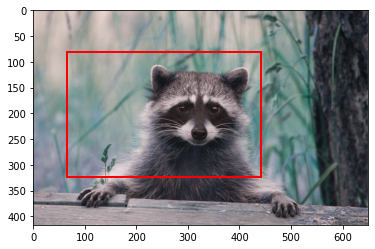

In [28]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()